<a href="https://colab.research.google.com/github/sushirito/Geodesic/blob/master/geodesic_a100_colab_using.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Geodesic-Coupled Spectral NODE - A100 Implementation
**Ultra-Parallel Training on NVIDIA A100 GPU with Google Drive Integration**

This notebook implements the complete Geodesic NODE system optimized for A100 GPUs, achieving massive parallelization of 18,030 simultaneous geodesics with coupled ODE dynamics.

## Key Features
- ✅ Coupled ODE System: [c, v, A] with dA/dt = f(c,v,λ)
- ✅ Pre-computed Christoffel Grid: 2000×601 points
- ✅ Mixed Precision Training (FP16/FP32)
- ✅ Leave-one-out Validation
- ✅ Google Drive Model Persistence

## 1. Setup & Environment Configuration

In [14]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install required packages
!pip install -q torchdiffeq plotly

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torchdiffeq import odeint, odeint_adjoint

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from pathlib import Path
import time
import json
from typing import Dict, Tuple, Optional, List
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Check GPU and set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0)
    print(f"🚀 Using GPU: {gpu_name}")
    if 'A100' in gpu_name:
        print("✅ A100 GPU detected! Ready for ultra-parallel training.")
    else:
        print(f"⚠️ Warning: Expected A100 but got {gpu_name}")
else:
    device = torch.device('cpu')
    print("⚠️ No GPU available, using CPU (will be slow)")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 Using GPU: NVIDIA A100-SXM4-40GB
✅ A100 GPU detected! Ready for ultra-parallel training.


In [15]:
# Define paths for Google Drive
DATA_PATH = "/content/drive/My Drive/RegeneronSTS/data/0.30MB_AuNP_As.csv"
MODEL_DIR = "/content/drive/My Drive/RegeneronSTS/models/"
CHECKPOINT_PATH = MODEL_DIR + "geodesic_a100_checkpoint.pt"
BEST_MODEL_PATH = MODEL_DIR + "geodesic_a100_best.pt"
VIZ_DIR = "/content/drive/My Drive/RegeneronSTS/visualizations/"

# Create directories if they don't exist
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
Path(VIZ_DIR).mkdir(parents=True, exist_ok=True)

print(f"📁 Data path: {DATA_PATH}")
print(f"💾 Model directory: {MODEL_DIR}")
print(f"📊 Visualization directory: {VIZ_DIR}")

# Configuration for A100 optimization - ADJUSTED FOR DEBUGGING
A100_CONFIG = {
    'batch_size': 1024,  # Reduced for debugging
    'christoffel_grid_size': (1000, 301),  # Reduced resolution
    'n_trajectory_points': 25,  # Fewer points for faster integration
    'shooting_max_iter': 20,  # Reduced iterations
    'shooting_tolerance': 1e-3,  # Relaxed tolerance
    'shooting_learning_rate': 0.8,  # Higher learning rate
    'n_epochs': 1,  # Fewer epochs for testing
    'learning_rate_metric': 1e-3,  # Higher learning rate
    'learning_rate_flow': 2e-3,  # Higher learning rate
    'use_mixed_precision': True,
    'gradient_clip': 2.0,  # Higher clip value
    'save_frequency': 10  # Save more frequently
}

print("\n⚙️ A100 Configuration (Debug Mode):")
for key, value in A100_CONFIG.items():
    print(f"  {key}: {value}")

print("\n🔧 Debug changes made:")
print("  - Reduced batch size for stability")
print("  - Relaxed shooting tolerance")
print("  - Increased learning rates")
print("  - Reduced grid resolution")
print("  - Fewer trajectory points")

📁 Data path: /content/drive/My Drive/RegeneronSTS/data/0.30MB_AuNP_As.csv
💾 Model directory: /content/drive/My Drive/RegeneronSTS/models/
📊 Visualization directory: /content/drive/My Drive/RegeneronSTS/visualizations/

⚙️ A100 Configuration (Debug Mode):
  batch_size: 1024
  christoffel_grid_size: (1000, 301)
  n_trajectory_points: 25
  shooting_max_iter: 20
  shooting_tolerance: 0.001
  shooting_learning_rate: 0.8
  n_epochs: 1
  learning_rate_metric: 0.001
  learning_rate_flow: 0.002
  use_mixed_precision: True
  gradient_clip: 2.0
  save_frequency: 10

🔧 Debug changes made:
  - Reduced batch size for stability
  - Relaxed shooting tolerance
  - Increased learning rates
  - Reduced grid resolution
  - Fewer trajectory points


## 2. Core Mathematical Components

In [26]:
class ChristoffelComputer:
    """Computes and caches Christoffel symbols for geodesic computation"""

    def __init__(self,
                 metric_network: torch.nn.Module,
                 grid_size: Tuple[int, int] = (2000, 601),
                 device: torch.device = torch.device('cuda'),
                 use_half_precision: bool = True):
        """
        Initialize Christoffel computer with pre-computed grid

        Args:
            metric_network: Neural network computing g(c,λ)
            grid_size: (concentration_points, wavelength_points)
            device: Computation device
            use_half_precision: Store grid in FP16 for memory efficiency
        """
        self.metric_network = metric_network
        self.grid_size = grid_size
        self.device = device
        self.use_half_precision = use_half_precision

        # Grid will be computed on first use or explicitly
        self.christoffel_grid: Optional[torch.Tensor] = None
        self.c_grid: Optional[torch.Tensor] = None
        self.lambda_grid: Optional[torch.Tensor] = None

    def precompute_grid(self, c_range: Tuple[float, float] = (-1, 1),
                       lambda_range: Tuple[float, float] = (-1, 1)) -> None:
        """
        Pre-compute Christoffel symbols on dense grid
        Single massive forward pass for efficiency

        Args:
            c_range: Normalized concentration range
            lambda_range: Normalized wavelength range
        """
        print(f"Pre-computing Christoffel grid {self.grid_size}...")
        start_time = time.time()

        # Create grid points
        c_points = torch.linspace(c_range[0], c_range[1], self.grid_size[0], device=self.device)
        lambda_points = torch.linspace(lambda_range[0], lambda_range[1], self.grid_size[1], device=self.device)

        # Store grid coordinates for interpolation
        self.c_grid = c_points
        self.lambda_grid = lambda_points

        # Create meshgrid for vectorized computation
        c_mesh, lambda_mesh = torch.meshgrid(c_points, lambda_points, indexing='ij')

        # Flatten for batch processing
        c_flat = c_mesh.flatten()
        lambda_flat = lambda_mesh.flatten()

        # Compute Christoffel symbols using finite differences
        christoffel_flat = self._compute_christoffel_batch(c_flat, lambda_flat)

        # Reshape to grid
        self.christoffel_grid = christoffel_flat.view(self.grid_size[0], self.grid_size[1])

        # Convert to half precision if requested (saves memory)
        if self.use_half_precision:
            self.christoffel_grid = self.christoffel_grid.half()

        compute_time = time.time() - start_time
        memory_mb = self.christoffel_grid.element_size() * self.christoffel_grid.nelement() / (1024**2)

        print(f"  Computation time: {compute_time:.2f}s")
        print(f"  Grid memory: {memory_mb:.2f} MB")
        print(f"  Grid range: Γ ∈ [{self.christoffel_grid.min():.4f}, {self.christoffel_grid.max():.4f}]")

    def _compute_christoffel_batch(self, c_batch: torch.Tensor,
                                  lambda_batch: torch.Tensor) -> torch.Tensor:
        """
        Compute Christoffel symbols for batch of points
        Γ = ½ g⁻¹ ∂g/∂c

        Args:
            c_batch: Concentration values [batch_size]
            lambda_batch: Wavelength values [batch_size]

        Returns:
            Christoffel symbols [batch_size]
        """
        eps = 1e-4  # Finite difference epsilon

        # Prepare perturbed inputs for finite differences
        c_plus = c_batch + eps
        c_minus = c_batch - eps

        # Stack inputs for single forward pass
        c_stacked = torch.cat([c_minus, c_batch, c_plus])
        lambda_stacked = torch.cat([lambda_batch, lambda_batch, lambda_batch])
        inputs_stacked = torch.stack([c_stacked, lambda_stacked], dim=1)

        # Single forward pass through metric network
        with torch.no_grad():
            g_values = self.metric_network(inputs_stacked)

        # Split results
        batch_size = c_batch.shape[0]
        g_minus = g_values[:batch_size]
        g_center = g_values[batch_size:2*batch_size]
        g_plus = g_values[2*batch_size:]

        # Compute derivative using central differences
        dg_dc = (g_plus - g_minus) / (2 * eps)

        # Compute Christoffel symbol
        # Add small epsilon to avoid division by zero
        christoffel = 0.5 * dg_dc / (g_center + 1e-10)

        return christoffel.squeeze()

    def interpolate(self, c: torch.Tensor, lambda_val: torch.Tensor) -> torch.Tensor:
        """
        Interpolate Christoffel symbols from pre-computed grid
        Uses bilinear interpolation for smooth values

        Args:
            c: Concentration values (normalized) [batch_size]
            lambda_val: Wavelength values (normalized) [batch_size]

        Returns:
            Interpolated Christoffel symbols [batch_size]
        """
        if self.christoffel_grid is None:
            raise RuntimeError("Christoffel grid not computed. Call precompute_grid() first.")

        batch_size = c.shape[0]

        # Convert to grid coordinates [-1, 1] -> [0, grid_size-1]
        c_norm = (c - self.c_grid[0]) / (self.c_grid[-1] - self.c_grid[0])
        lambda_norm = (lambda_val - self.lambda_grid[0]) / (self.lambda_grid[-1] - self.lambda_grid[0])

        # Convert to grid indices
        c_idx = c_norm * (self.grid_size[0] - 1)
        lambda_idx = lambda_norm * (self.grid_size[1] - 1)

        # Stack for grid_sample (expects [N, 2] for 2D grid)
        # Note: grid_sample expects coordinates in (x,y) = (width, height) order
        # So we need (lambda, c) not (c, lambda)
        grid_coords = torch.stack([lambda_idx * 2 - 1, c_idx * 2 - 1], dim=1)

        # Reshape grid for grid_sample [N, 1, H, W] - repeat for batch
        grid = self.christoffel_grid.float().unsqueeze(0).unsqueeze(0)
        grid = grid.expand(batch_size, 1, self.grid_size[0], self.grid_size[1])

        # Reshape coordinates for grid_sample [N, 1, 1, 2]
        grid_coords = grid_coords.view(batch_size, 1, 1, 2)

        # Bilinear interpolation
        interpolated = F.grid_sample(grid, grid_coords,
                                    mode='bilinear',
                                    padding_mode='border',
                                    align_corners=True)

        # Reshape output [N, 1, 1, 1] -> [N]
        return interpolated.squeeze()

    def get_grid_stats(self) -> dict:
        """Get statistics about the pre-computed grid"""
        if self.christoffel_grid is None:
            return {"status": "Grid not computed"}

        return {
            "grid_size": self.grid_size,
            "memory_mb": self.christoffel_grid.element_size() * self.christoffel_grid.nelement() / (1024**2),
            "dtype": str(self.christoffel_grid.dtype),
            "min_value": float(self.christoffel_grid.min()),
            "max_value": float(self.christoffel_grid.max()),
            "mean_value": float(self.christoffel_grid.mean()),
            "std_value": float(self.christoffel_grid.std())
        }

In [27]:
class GeodesicODEFunc(nn.Module):
    """Neural ODE function wrapper for adjoint method compatibility"""

    def __init__(self, christoffel_computer, spectral_flow_network, wavelengths):
        super().__init__()
        self.christoffel_computer = christoffel_computer
        self.spectral_flow_network = spectral_flow_network
        self.wavelengths = wavelengths

    def forward(self, t, state):
        """
        Coupled geodesic-spectral ODE system:
        dc/dt = v
        dv/dt = -Γ(c,λ)v²
        dA/dt = f(c,v,λ)
        """
        # Extract state components
        c = state[:, 0]
        v = state[:, 1]
        A = state[:, 2]

        # Get Christoffel symbols via interpolation
        christoffel = self.christoffel_computer.interpolate(c, self.wavelengths)

        # Compute geodesic derivatives
        dc_dt = v
        dv_dt = -christoffel * v * v

        # Compute spectral flow using neural network
        # f(c,v,λ) models how absorbance changes along geodesic
        flow_input = torch.stack([c, v, self.wavelengths], dim=1)
        dA_dt = self.spectral_flow_network(flow_input).squeeze(-1)

        # Ensure dA_dt has same shape as other derivatives
        if dA_dt.dim() == 0:
            dA_dt = dA_dt.unsqueeze(0)

        # Stack all derivatives for coupled system
        derivatives = torch.stack([dc_dt, dv_dt, dA_dt], dim=1)

        return derivatives


class GeodesicIntegrator:
    """Integrates coupled geodesic-spectral ODEs for massive batches simultaneously"""

    def __init__(self,
                 christoffel_computer: 'ChristoffelComputer',
                 spectral_flow_network: torch.nn.Module,
                 device: torch.device = torch.device('cuda'),
                 use_adjoint: bool = True):
        """
        Initialize geodesic integrator with coupled dynamics

        Args:
            christoffel_computer: Pre-computed Christoffel symbols
            spectral_flow_network: Network for spectral flow dA/dt = f(c,v,λ)
            device: Computation device
            use_adjoint: Use adjoint method for memory efficiency
        """
        self.christoffel_computer = christoffel_computer
        self.spectral_flow_network = spectral_flow_network
        self.device = device
        self.use_adjoint = use_adjoint

    def integrate_batch(self,
                       initial_states: torch.Tensor,
                       wavelengths: torch.Tensor,
                       t_span: torch.Tensor,
                       method: str = 'dopri5',
                       rtol: float = 1e-5,
                       atol: float = 1e-7) -> Dict[str, torch.Tensor]:
        """
        Integrate geodesic ODEs for massive batch

        State vector: [c, v, A] where:
            c: concentration
            v: velocity dc/dt
            A: absorbance (evolves through coupled ODE)

        Args:
            initial_states: Initial [c, v, A] states [batch_size, 3]
            wavelengths: Wavelength values [batch_size]
            t_span: Time points for integration [n_time_points]
            method: ODE solver method
            rtol: Relative tolerance
            atol: Absolute tolerance

        Returns:
            Dictionary with:
                - trajectories: Full state evolution [n_time_points, batch_size, 3]
                - final_states: Final states [batch_size, 3]
                - final_absorbance: Final A values [batch_size]
        """
        batch_size = initial_states.shape[0]
        assert initial_states.shape[1] == 3, "State must be [c, v, A] with dimension 3"

        # Create ODE function as nn.Module for adjoint compatibility
        ode_func = GeodesicODEFunc(
            self.christoffel_computer,
            self.spectral_flow_network,
            wavelengths
        ).to(self.device)

        # Choose integration method
        if self.use_adjoint and initial_states.requires_grad:
            # Use adjoint method for memory efficiency during training
            trajectories = odeint_adjoint(
                ode_func,
                initial_states,
                t_span,
                method=method,
                rtol=rtol,
                atol=atol
            )
        else:
            # Standard integration for inference
            trajectories = odeint(
                ode_func,
                initial_states,
                t_span,
                method=method,
                rtol=rtol,
                atol=atol
            )

        # Extract final states
        final_states = trajectories[-1]

        # Extract final absorbance (the prediction)
        final_absorbance = final_states[:, 2]

        return {
            'trajectories': trajectories,
            'final_states': final_states,
            'final_absorbance': final_absorbance
        }

    def parallel_integrate(self,
                          c_sources: torch.Tensor,
                          c_targets: torch.Tensor,
                          wavelengths: torch.Tensor,
                          initial_velocities: torch.Tensor,
                          n_time_points: int = 50) -> Dict[str, torch.Tensor]:
        """
        Convenience method for parallel integration of multiple geodesics

        Args:
            c_sources: Source concentrations [batch_size]
            c_targets: Target concentrations [batch_size] (for validation)
            wavelengths: Wavelengths [batch_size]
            initial_velocities: Initial velocities from shooting solver [batch_size]
            n_time_points: Number of time points for trajectory

        Returns:
            Integration results dictionary
        """
        batch_size = c_sources.shape[0]

        # Prepare initial states with zero initial absorbance
        # A(t=0) = 0 for concentration transitions
        initial_A = torch.zeros(batch_size, device=self.device)
        initial_states = torch.stack([c_sources, initial_velocities, initial_A], dim=1)

        # Time span from 0 to 1
        t_span = torch.linspace(0, 1, n_time_points, device=self.device)

        # Integrate
        results = self.integrate_batch(
            initial_states=initial_states,
            wavelengths=wavelengths,
            t_span=t_span
        )

        # Add endpoint validation
        c_final = results['final_states'][:, 0]
        c_endpoint_error = (c_final - c_targets).abs()
        results['c_endpoint_error'] = c_endpoint_error
        results['mean_c_error'] = c_endpoint_error.mean()

        return results

In [28]:
class ShootingSolver:
    """Solves BVP using parallel shooting method for massive batches"""

    def __init__(self,
                 geodesic_integrator: 'GeodesicIntegrator',
                 max_iterations: int = 10,
                 tolerance: float = 1e-4,
                 learning_rate: float = 0.5,
                 device: torch.device = torch.device('cuda')):
        """
        Initialize shooting solver

        Args:
            geodesic_integrator: Integrator for geodesic ODEs
            max_iterations: Maximum shooting iterations
            tolerance: Convergence tolerance for endpoint error
            learning_rate: Step size for velocity updates
            device: Computation device
        """
        self.integrator = geodesic_integrator
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.learning_rate = learning_rate
        self.device = device

    def solve_batch(self,
                   c_sources: torch.Tensor,
                   c_targets: torch.Tensor,
                   wavelengths: torch.Tensor,
                   n_trajectory_points: int = 50) -> Dict[str, torch.Tensor]:
        """
        Solve BVP for batch of geodesics
        Find initial velocities v₀ such that geodesic(c_source, v₀, t=1) = c_target

        Args:
            c_sources: Source concentrations [batch_size]
            c_targets: Target concentrations [batch_size]
            wavelengths: Wavelengths [batch_size]
            n_trajectory_points: Points for trajectory discretization

        Returns:
            Dictionary with:
                - initial_velocities: Optimal v₀ [batch_size]
                - trajectories: Full geodesic paths [n_points, batch_size, 3]
                - final_absorbance: Predicted absorbance values [batch_size]
                - final_errors: Endpoint errors [batch_size]
                - convergence_mask: Which geodesics converged [batch_size]
        """
        batch_size = c_sources.shape[0]

        # Initial guess: linear interpolation velocity
        v_initial = c_targets - c_sources

        # Track best solutions
        best_velocities = v_initial.clone()
        best_errors = torch.full((batch_size,), float('inf'), device=self.device)
        convergence_mask = torch.zeros(batch_size, dtype=torch.bool, device=self.device)

        # Fixed iterations for parallelism (no early stopping)
        for iteration in range(self.max_iterations):
            # Integrate with current velocities (A starts at 0)
            initial_A = torch.zeros_like(c_sources)
            initial_states = torch.stack([c_sources, v_initial, initial_A], dim=1)
            t_span = torch.tensor([0.0, 1.0], device=self.device)

            # Quick integration for shooting (only need endpoints)
            results = self.integrator.integrate_batch(
                initial_states=initial_states,
                wavelengths=wavelengths,
                t_span=t_span,
                method='rk4',  # Faster for shooting
                rtol=1e-3,  # Looser tolerance for shooting
                atol=1e-5
            )

            # Get final concentrations
            c_final = results['final_states'][:, 0]

            # FIXED: Proper error computation - was this the bug?
            errors = (c_final - c_targets).abs()

            # DEBUG: Print some diagnostics
            if iteration == 0:
                print(f"DEBUG: c_sources range: [{c_sources.min():.3f}, {c_sources.max():.3f}]")
                print(f"DEBUG: c_targets range: [{c_targets.min():.3f}, {c_targets.max():.3f}]")
                print(f"DEBUG: c_final range: [{c_final.min():.3f}, {c_final.max():.3f}]")
                print(f"DEBUG: errors range: [{errors.min():.6f}, {errors.max():.6f}]")
                print(f"DEBUG: tolerance: {self.tolerance}")

            # Update best solutions
            improved_mask = errors < best_errors
            best_velocities[improved_mask] = v_initial[improved_mask]
            best_errors[improved_mask] = errors[improved_mask]

            # FIXED: Proper convergence check - this was likely the bug
            newly_converged = (errors < self.tolerance) & ~convergence_mask
            convergence_mask |= newly_converged

            # Simple velocity update
            velocity_gradient = (c_final - c_targets)

            # Update velocities (except for converged ones)
            update_mask = ~convergence_mask
            v_initial[update_mask] -= self.learning_rate * velocity_gradient[update_mask]

            # Adaptive learning rate decay
            if iteration > 0 and iteration % 3 == 0:
                self.learning_rate *= 0.8

        # DEBUG: Final convergence info
        final_convergence_rate = convergence_mask.float().mean()
        print(f"DEBUG: Final convergence rate: {final_convergence_rate:.1%}")
        print(f"DEBUG: Final best errors range: [{best_errors.min():.6f}, {best_errors.max():.6f}]")
        print(f"DEBUG: Number converged: {convergence_mask.sum().item()}/{batch_size}")

        # Final integration with best velocities for full trajectories
        initial_A = torch.zeros_like(c_sources)
        initial_states = torch.stack([c_sources, best_velocities, initial_A], dim=1)
        t_span = torch.linspace(0, 1, n_trajectory_points, device=self.device)

        final_results = self.integrator.integrate_batch(
            initial_states=initial_states,
            wavelengths=wavelengths,
            t_span=t_span,
            rtol=1e-5,
            atol=1e-7
        )

        # Prepare output
        return {
            'initial_velocities': best_velocities,
            'trajectories': final_results['trajectories'],
            'final_absorbance': final_results['final_absorbance'],
            'final_errors': best_errors,
            'convergence_mask': convergence_mask,
            'convergence_rate': convergence_mask.float().mean(),
            'mean_error': best_errors.mean()
        }

    def solve_parallel(self,
                       concentration_pairs: torch.Tensor,
                       wavelength_grid: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Solve all 18,030 geodesics in parallel

        Args:
            concentration_pairs: All concentration transitions [30, 2]
            wavelength_grid: All wavelengths [601]

        Returns:
            Complete solution dictionary for all geodesics
        """
        # Create all combinations
        n_pairs = concentration_pairs.shape[0]
        n_wavelengths = wavelength_grid.shape[0]
        total_geodesics = n_pairs * n_wavelengths

        print(f"Solving {total_geodesics:,} geodesics in parallel...")

        # Expand to all combinations
        # Repeat each pair for all wavelengths
        c_sources = concentration_pairs[:, 0].repeat_interleave(n_wavelengths)
        c_targets = concentration_pairs[:, 1].repeat_interleave(n_wavelengths)

        # Tile wavelengths for all pairs
        wavelengths = wavelength_grid.repeat(n_pairs)

        # Solve all BVPs
        results = self.solve_batch(
            c_sources=c_sources,
            c_targets=c_targets,
            wavelengths=wavelengths
        )

        print(f"  Convergence rate: {results['convergence_rate']:.1%}")
        print(f"  Mean endpoint error: {results['mean_error']:.6f}")

        return results

## 3. Neural Network Models

In [29]:
class MetricNetwork(nn.Module):
    """Neural network learning the Riemannian metric of spectral space"""

    def __init__(self,
                 input_dim: int = 2,
                 hidden_dims: list = None,
                 activation: str = 'tanh',
                 use_batch_norm: bool = False):
        """
        Initialize metric network

        Args:
            input_dim: Input dimension [c, λ]
            hidden_dims: Hidden layer dimensions (must be multiples of 8 for Tensor Cores)
            activation: Activation function
            use_batch_norm: Whether to use batch normalization
        """
        super().__init__()

        if hidden_dims is None:
            hidden_dims = [128, 256]  # Tensor Core optimized

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.use_batch_norm = use_batch_norm

        # Build network layers
        layers = []
        in_features = input_dim

        for i, hidden_dim in enumerate(hidden_dims):
            # Linear layer
            layers.append(nn.Linear(in_features, hidden_dim))

            # Batch norm (optional)
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))

            # Activation
            if activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'gelu':
                layers.append(nn.GELU())
            else:
                raise ValueError(f"Unknown activation: {activation}")

            in_features = hidden_dim

        # Output layer (no activation, will apply softplus for positivity)
        layers.append(nn.Linear(in_features, 1))

        self.network = nn.Sequential(*layers)

        # Initialize weights for stability
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights using Xavier initialization"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        Forward pass computing metric value

        Args:
            inputs: [batch_size, 2] containing [c, λ]

        Returns:
            g(c,λ): Positive metric values [batch_size, 1]
        """
        # Ensure inputs are properly shaped
        if inputs.dim() == 1:
            inputs = inputs.unsqueeze(0)

        # Forward through network
        raw_output = self.network(inputs)

        # Apply softplus to ensure positivity with minimum value
        # g(c,λ) = softplus(raw) + 0.1
        # This ensures g > 0.1 for numerical stability
        metric = F.softplus(raw_output) + 0.1

        return metric

    def compute_derivatives(self, c: torch.Tensor, wavelength: torch.Tensor,
                          create_graph: bool = False) -> dict:
        """
        Compute metric and its derivatives

        Args:
            c: Concentration values [batch_size]
            wavelength: Wavelength values [batch_size]
            create_graph: Whether to create computation graph for higher derivatives

        Returns:
            Dictionary with metric value and derivatives
        """
        # Enable gradients
        c = c.requires_grad_(True)

        # Stack inputs
        inputs = torch.stack([c, wavelength], dim=1)

        # Compute metric
        g = self.forward(inputs)

        # Compute first derivative dg/dc
        dg_dc = torch.autograd.grad(
            outputs=g.sum(),
            inputs=c,
            create_graph=create_graph,
            retain_graph=True
        )[0]

        results = {
            'g': g.squeeze(),
            'dg_dc': dg_dc
        }

        # Optionally compute second derivative
        if create_graph:
            d2g_dc2 = torch.autograd.grad(
                outputs=dg_dc.sum(),
                inputs=c,
                create_graph=False,
                retain_graph=False
            )[0]
            results['d2g_dc2'] = d2g_dc2

        return results

    def get_smoothness_loss(self, c_batch: torch.Tensor,
                          wavelength_batch: torch.Tensor) -> torch.Tensor:
        """
        Compute smoothness regularization loss
        Penalizes rapid changes in metric curvature

        Args:
            c_batch: Concentration values [batch_size]
            wavelength_batch: Wavelength values [batch_size]

        Returns:
            Smoothness loss scalar
        """
        # FIXED: Ensure we have enough samples and proper gradient computation
        if c_batch.numel() == 0:
            return torch.tensor(0.0, device=c_batch.device, requires_grad=True)

        # Sample a subset if batch is too large (for efficiency)
        max_samples = min(64, len(c_batch))
        if len(c_batch) > max_samples:
            indices = torch.randperm(len(c_batch))[:max_samples]
            c_sample = c_batch[indices]
            wl_sample = wavelength_batch[indices]
        else:
            c_sample = c_batch
            wl_sample = wavelength_batch

        try:
            # Compute second derivatives
            derivatives = self.compute_derivatives(c_sample, wl_sample, create_graph=True)

            # L2 penalty on second derivative
            if 'd2g_dc2' in derivatives and derivatives['d2g_dc2'] is not None:
                smoothness = (derivatives['d2g_dc2'] ** 2).mean()
                # Ensure it requires gradients
                if not smoothness.requires_grad:
                    smoothness = smoothness.requires_grad_(True)
                return smoothness
            else:
                return torch.tensor(0.0, device=c_batch.device, requires_grad=True)

        except Exception as e:
            print(f"Warning: Smoothness loss computation failed: {e}")
            return torch.tensor(0.0, device=c_batch.device, requires_grad=True)

    def get_bounds_loss(self, c_batch: torch.Tensor,
                       wavelength_batch: torch.Tensor,
                       min_val: float = 0.01,
                       max_val: float = 100.0) -> torch.Tensor:
        """
        Compute bounds regularization loss
        Keeps metric values in reasonable range

        Args:
            c_batch: Concentration values [batch_size]
            wavelength_batch: Wavelength values [batch_size]
            min_val: Minimum allowed metric value
            max_val: Maximum allowed metric value

        Returns:
            Bounds loss scalar
        """
        inputs = torch.stack([c_batch, wavelength_batch], dim=1)
        g = self.forward(inputs).squeeze()

        # Penalize values outside bounds
        lower_violation = F.relu(min_val - g)
        upper_violation = F.relu(g - max_val)

        bounds_loss = lower_violation.mean() + upper_violation.mean()

        return bounds_loss


class SpectralFlowNetwork(nn.Module):
    """Neural network modeling spectral flow dA/dt along geodesics"""

    def __init__(self,
                 input_dim: int = 3,
                 hidden_dims: list = None,
                 activation: str = 'tanh'):
        """
        Initialize spectral flow network

        Args:
            input_dim: Input dimension [c, v, λ]
            hidden_dims: Hidden layer dimensions (Tensor Core optimized)
            activation: Activation function
        """
        super().__init__()

        if hidden_dims is None:
            hidden_dims = [64, 128]  # Tensor Core friendly

        self.input_dim = input_dim
        self.hidden_dims = hidden_dims

        # Build network layers
        layers = []
        in_features = input_dim

        for hidden_dim in hidden_dims:
            # Linear layer
            layers.append(nn.Linear(in_features, hidden_dim))

            # Activation
            if activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'gelu':
                layers.append(nn.GELU())
            else:
                raise ValueError(f"Unknown activation: {activation}")

            in_features = hidden_dim

        # Output layer for dA/dt
        layers.append(nn.Linear(in_features, 1))

        self.network = nn.Sequential(*layers)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights for stable ODE dynamics"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                # Small initialization to prevent explosive dynamics
                nn.init.xavier_uniform_(module.weight, gain=0.1)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        """
        Forward pass computing spectral flow rate

        Args:
            inputs: [batch_size, 3] containing [c, v, λ]

        Returns:
            dA/dt: Rate of absorbance change [batch_size, 1]
        """
        # Ensure inputs are properly shaped
        if inputs.dim() == 1:
            inputs = inputs.unsqueeze(0)

        # Forward through network
        dA_dt = self.network(inputs)

        return dA_dt

In [30]:
class GeodesicNODE(nn.Module):
    """Complete Geodesic-Coupled Neural ODE system for spectral prediction"""

    def __init__(self,
                 metric_hidden_dims: list = None,
                 flow_hidden_dims: list = None,
                 n_trajectory_points: int = 50,
                 shooting_max_iter: int = 10,
                 shooting_tolerance: float = 1e-4,
                 shooting_learning_rate: float = 0.5,
                 christoffel_grid_size: tuple = (2000, 601),
                 device: torch.device = None,
                 use_adjoint: bool = True):
        """
        Initialize complete geodesic NODE system

        Args:
            metric_hidden_dims: Hidden dims for metric network
            flow_hidden_dims: Hidden dims for spectral flow network
            n_trajectory_points: Points for trajectory discretization
            shooting_max_iter: Max iterations for BVP solver
            shooting_tolerance: Convergence tolerance for shooting
            shooting_learning_rate: Learning rate for shooting method
            christoffel_grid_size: Grid resolution for Christoffel symbols
            device: Computation device
            use_adjoint: Use adjoint method for backprop
        """
        super().__init__()

        if device is None:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.device = device

        # Initialize neural networks
        self.metric_network = MetricNetwork(
            input_dim=2,
            hidden_dims=metric_hidden_dims,
            activation='tanh'
        ).to(device)

        self.spectral_flow_network = SpectralFlowNetwork(
            input_dim=3,
            hidden_dims=flow_hidden_dims,
            activation='tanh'
        ).to(device)

        # Initialize mathematical components
        self.christoffel_computer = ChristoffelComputer(
            metric_network=self.metric_network,
            grid_size=christoffel_grid_size,
            device=device,
            use_half_precision=True
        )

        self.geodesic_integrator = GeodesicIntegrator(
            christoffel_computer=self.christoffel_computer,
            spectral_flow_network=self.spectral_flow_network,
            device=device,
            use_adjoint=use_adjoint
        )

        self.shooting_solver = ShootingSolver(
            geodesic_integrator=self.geodesic_integrator,
            max_iterations=shooting_max_iter,
            tolerance=shooting_tolerance,
            learning_rate=shooting_learning_rate,
            device=device
        )

        # Configuration
        self.n_trajectory_points = n_trajectory_points
        self.christoffel_grid_computed = False

    def precompute_christoffel_grid(self, c_range: tuple = (-1, 1),
                                   lambda_range: tuple = (-1, 1)):
        """
        Pre-compute Christoffel symbols on grid for efficiency

        Args:
            c_range: Normalized concentration range
            lambda_range: Normalized wavelength range
        """
        self.christoffel_computer.precompute_grid(c_range, lambda_range)
        self.christoffel_grid_computed = True

    def forward(self, c_sources: torch.Tensor, c_targets: torch.Tensor,
                wavelengths: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Forward pass through geodesic NODE system

        Args:
            c_sources: Source concentrations [batch_size]
            c_targets: Target concentrations [batch_size]
            wavelengths: Wavelengths [batch_size]

        Returns:
            Dictionary with:
                - absorbance: Predicted absorbance at target [batch_size]
                - trajectories: Full state evolution [n_points, batch_size, 3]
                - initial_velocities: Optimal v₀ from shooting [batch_size]
                - convergence_mask: Which geodesics converged [batch_size]
        """
        # Ensure Christoffel grid is computed
        if not self.christoffel_grid_computed:
            self.precompute_christoffel_grid()

        # Solve BVP to find initial velocities
        bvp_results = self.shooting_solver.solve_batch(
            c_sources=c_sources,
            c_targets=c_targets,
            wavelengths=wavelengths,
            n_trajectory_points=self.n_trajectory_points
        )

        # Extract results
        return {
            'absorbance': bvp_results['final_absorbance'],
            'trajectories': bvp_results['trajectories'],
            'initial_velocities': bvp_results['initial_velocities'],
            'convergence_mask': bvp_results['convergence_mask'],
            'convergence_rate': bvp_results['convergence_rate']
        }

    def compute_loss(self, predictions: Dict[str, torch.Tensor],
                    targets: torch.Tensor,
                    c_batch: torch.Tensor,
                    wavelength_batch: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Compute multi-component loss

        Args:
            predictions: Model predictions dictionary
            targets: Target absorbance values [batch_size]
            c_batch: Concentration values for regularization [batch_size]
            wavelength_batch: Wavelength values for regularization [batch_size]

        Returns:
            Dictionary with loss components
        """
        # Reconstruction loss
        reconstruction_loss = nn.functional.mse_loss(
            predictions['absorbance'], targets
        )

        # DEBUG: Add print to see if smoothness loss is being computed
        print(f"DEBUG: Computing smoothness loss for batch size {c_batch.shape[0]}")

        # Metric smoothness regularization
        smoothness_loss = self.metric_network.get_smoothness_loss(
            c_batch, wavelength_batch
        )

        print(f"DEBUG: Smoothness loss computed: {smoothness_loss.item():.6f}")

        # Metric bounds regularization
        bounds_loss = self.metric_network.get_bounds_loss(
            c_batch, wavelength_batch
        )

        # Path length regularization (efficiency)
        if 'trajectories' in predictions:
            trajectories = predictions['trajectories']
            velocities = trajectories[:, :, 1]  # [n_points, batch_size]
            path_lengths = velocities.abs().mean(dim=0).mean()
        else:
            path_lengths = torch.tensor(0.0, device=self.device)

        # Total loss with weights
        total_loss = (
            reconstruction_loss +
            0.01 * smoothness_loss +
            0.001 * bounds_loss +
            0.001 * path_lengths
        )

        return {
            'total': total_loss,
            'reconstruction': reconstruction_loss,
            'smoothness': smoothness_loss,
            'bounds': bounds_loss,
            'path_length': path_lengths
        }

    def parallel_forward(self, concentration_pairs: torch.Tensor,
                        wavelength_grid: torch.Tensor) -> Dict[str, torch.Tensor]:
        """
        Process all 18,030 geodesics in parallel

        Args:
            concentration_pairs: All concentration transitions [30, 2]
            wavelength_grid: All wavelengths [601]

        Returns:
            Complete results for all geodesics
        """
        # Ensure grid is computed
        if not self.christoffel_grid_computed:
            self.precompute_christoffel_grid()

        # Use shooting solver's parallel method
        return self.shooting_solver.solve_parallel(
            concentration_pairs, wavelength_grid
        )

    def save_checkpoint(self, path: str, epoch: int, optimizers: dict = None, best_loss: float = None):
        """Save model checkpoint to Google Drive"""
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'metric_network_state': self.metric_network.state_dict(),
            'flow_network_state': self.spectral_flow_network.state_dict(),
            'christoffel_grid': self.christoffel_computer.christoffel_grid.cpu() if self.christoffel_computer.christoffel_grid is not None else None,
            'config': {
                'grid_size': self.christoffel_computer.grid_size,
                'n_trajectory_points': self.n_trajectory_points
            }
        }

        if optimizers:
            checkpoint['optimizers'] = {k: v.state_dict() for k, v in optimizers.items()}

        if best_loss is not None:
            checkpoint['best_loss'] = best_loss

        torch.save(checkpoint, path)
        print(f"💾 Checkpoint saved to {path}")

    def load_checkpoint(self, path: str, load_optimizers: bool = False):
        """Load model checkpoint from Google Drive"""
        checkpoint = torch.load(path, map_location=self.device, weights_only=False)

        self.load_state_dict(checkpoint['model_state_dict'])
        self.metric_network.load_state_dict(checkpoint['metric_network_state'])
        self.spectral_flow_network.load_state_dict(checkpoint['flow_network_state'])

        if 'christoffel_grid' in checkpoint and checkpoint['christoffel_grid'] is not None:
            self.christoffel_computer.christoffel_grid = checkpoint['christoffel_grid'].to(self.device)
            self.christoffel_computer.is_computed = True
            self.christoffel_grid_computed = True

        print(f"✅ Model loaded from {path} (epoch {checkpoint['epoch']})")

        if load_optimizers and 'optimizers' in checkpoint:
            return checkpoint['optimizers']

        return checkpoint.get('epoch', 0)

## 4. Data Pipeline

In [31]:
class SpectralDataset:
    """Dataset for spectral concentration transitions"""

    def __init__(self,
                 concentration_values: list = None,
                 wavelengths: np.ndarray = None,
                 absorbance_data: np.ndarray = None,
                 excluded_concentration_idx: int = None,
                 normalize: bool = True,
                 device: torch.device = torch.device('cuda'),
                 csv_path: str = None):
        """
        Initialize spectral dataset

        Args:
            concentration_values: List of concentration values in ppb
            wavelengths: Wavelength array (nm)
            absorbance_data: Absorbance matrix [n_concentrations, n_wavelengths]
            excluded_concentration_idx: Which concentration to exclude (for leave-one-out)
            normalize: Whether to normalize inputs
            device: Device for tensor storage
        """
        # Load from CSV if path provided
        if csv_path is not None:
            df = pd.read_csv(csv_path)
            wavelengths = df['Wavelength'].values
            concentration_values = [float(col) for col in df.columns[1:]]
            absorbance_data = df.iloc[:, 1:].values.T  # Transpose to [n_conc, n_wave]

        # Use defaults if not provided
        if concentration_values is None:
            concentration_values = [0, 10, 20, 30, 40, 60]  # ppb

        if wavelengths is None:
            wavelengths = np.linspace(200, 800, 601)  # nm

        if absorbance_data is None:
            # Generate synthetic data only as fallback
            absorbance_data = self._generate_synthetic_data(
                concentration_values, wavelengths
            )

        self.concentration_values = np.array(concentration_values)
        self.wavelengths = wavelengths
        self.absorbance_data = absorbance_data
        self.excluded_idx = excluded_concentration_idx
        self.normalize = normalize
        self.device = device

        # Normalization parameters
        self.c_mean = 30.0  # ppb
        self.c_std = 30.0
        self.lambda_mean = 500.0  # nm
        self.lambda_std = 300.0
        self.A_mean = absorbance_data.mean()
        self.A_std = absorbance_data.std()

        # Create concentration transition pairs
        self._create_transition_pairs()

        # Move data to GPU
        self._prepare_gpu_tensors()

        print(f"📊 Dataset initialized: {len(self.transition_pairs)} pairs × {len(wavelengths)} wavelengths = {len(self):,} samples")
        if excluded_concentration_idx is not None:
            print(f"   Excluded concentration: {concentration_values[excluded_concentration_idx]} ppb")

    def _generate_synthetic_data(self, concentrations: list, wavelengths: np.ndarray) -> np.ndarray:
        """Generate synthetic absorbance data for testing"""
        n_conc = len(concentrations)
        n_wave = len(wavelengths)

        # Simple synthetic model: A = c * f(λ) with some nonlinearity
        absorbance = np.zeros((n_conc, n_wave))

        for i, c in enumerate(concentrations):
            for j, λ in enumerate(wavelengths):
                # Nonlinear response with wavelength-dependent sensitivity
                sensitivity = np.exp(-(λ - 450)**2 / (2 * 100**2))  # Peak at 450nm
                absorbance[i, j] = (c / 60) * sensitivity * (1 + 0.1 * np.sin(λ / 50))

        return absorbance

    def _create_transition_pairs(self):
        """Create all concentration transition pairs"""
        n_conc = len(self.concentration_values)
        pairs = []

        # Create all (source, target) pairs excluding self-transitions
        for i in range(n_conc):
            if self.excluded_idx is not None and i == self.excluded_idx:
                continue  # Skip excluded concentration

            for j in range(n_conc):
                if self.excluded_idx is not None and j == self.excluded_idx:
                    continue  # Skip excluded concentration

                if i != j:  # No self-transitions
                    pairs.append((i, j))

        self.transition_pairs = pairs

    def _prepare_gpu_tensors(self):
        """Pre-allocate and transfer data to GPU"""
        # Convert to tensors
        self.c_tensor = torch.tensor(
            self.concentration_values, dtype=torch.float32, device=self.device
        )
        self.lambda_tensor = torch.tensor(
            self.wavelengths, dtype=torch.float32, device=self.device
        )
        self.A_tensor = torch.tensor(
            self.absorbance_data, dtype=torch.float32, device=self.device
        )

        # Normalized versions
        if self.normalize:
            self.c_norm = (self.c_tensor - self.c_mean) / self.c_std
            self.lambda_norm = (self.lambda_tensor - self.lambda_mean) / self.lambda_std
            self.A_norm = (self.A_tensor - self.A_mean) / self.A_std
        else:
            self.c_norm = self.c_tensor
            self.lambda_norm = self.lambda_tensor
            self.A_norm = self.A_tensor

    def __len__(self) -> int:
        """Total number of training samples"""
        return len(self.transition_pairs) * len(self.wavelengths)

    def __getitem__(self, idx: int):
        """Get single training sample"""
        # Decompose index into pair and wavelength
        n_wavelengths = len(self.wavelengths)
        pair_idx = idx // n_wavelengths
        wave_idx = idx % n_wavelengths

        # Get concentration pair
        c_source_idx, c_target_idx = self.transition_pairs[pair_idx]

        # Get normalized values
        c_source = self.c_norm[c_source_idx]
        c_target = self.c_norm[c_target_idx]
        wavelength = self.lambda_norm[wave_idx]
        absorbance_target = self.A_norm[c_target_idx, wave_idx]

        return c_source, c_target, wavelength, absorbance_target

    def get_batch(self, batch_size: int = None):
        """Get entire dataset or batch as tensors (for parallel processing)"""
        if batch_size is None:
            # Return entire dataset
            n_pairs = len(self.transition_pairs)
            n_waves = len(self.wavelengths)

            # Pre-allocate tensors
            c_sources = torch.zeros(n_pairs * n_waves, device=self.device)
            c_targets = torch.zeros(n_pairs * n_waves, device=self.device)
            wavelengths = torch.zeros(n_pairs * n_waves, device=self.device)
            absorbances = torch.zeros(n_pairs * n_waves, device=self.device)

            idx = 0
            for pair_idx, (c_s_idx, c_t_idx) in enumerate(self.transition_pairs):
                for wave_idx in range(n_waves):
                    c_sources[idx] = self.c_norm[c_s_idx]
                    c_targets[idx] = self.c_norm[c_t_idx]
                    wavelengths[idx] = self.lambda_norm[wave_idx]
                    absorbances[idx] = self.A_norm[c_t_idx, wave_idx]
                    idx += 1

            return c_sources, c_targets, wavelengths, absorbances

        else:
            # Random batch
            indices = torch.randint(0, len(self), (batch_size,), device=self.device)
            batch_data = [self[idx] for idx in indices]
            return tuple(torch.stack(tensors) for tensors in zip(*batch_data))

    def denormalize_absorbance(self, A_norm: torch.Tensor) -> torch.Tensor:
        """Convert normalized absorbance back to original scale"""
        return A_norm * self.A_std + self.A_mean

    def get_dataloader(self, batch_size: int, shuffle: bool = True):
        """Create DataLoader for training"""
        from torch.utils.data import DataLoader
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle)


def create_data_loaders(concentration_values: list = None,
                       wavelengths: np.ndarray = None,
                       absorbance_data: np.ndarray = None,
                       batch_size: int = 2048,
                       device: torch.device = torch.device('cuda'),
                       csv_path: str = None) -> dict:
    """
    Create data loaders for leave-one-out validation

    Args:
        concentration_values: List of concentration values
        wavelengths: Wavelength array
        absorbance_data: Absorbance matrix
        batch_size: Batch size for training
        device: Computation device

    Returns:
        Dictionary with datasets for each leave-one-out split
    """
    loaders = {}

    n_concentrations = 6 if concentration_values is None else len(concentration_values)

    for excluded_idx in range(n_concentrations):
        dataset = SpectralDataset(
            concentration_values=concentration_values,
            wavelengths=wavelengths,
            absorbance_data=absorbance_data,
            excluded_concentration_idx=excluded_idx,
            normalize=True,
            device=device,
            csv_path=csv_path
        )

        # For A100, we can often load entire dataset at once
        # So we'll use a simple DataLoader with large batch size
        loader = dataset.get_dataloader(
            batch_size=min(batch_size, len(dataset)),
            shuffle=True
        )

        loaders[f'exclude_{excluded_idx}'] = {
            'dataset': dataset,
            'loader': loader,
            'excluded_concentration': dataset.concentration_values[excluded_idx]
        }

    return loaders

In [32]:
def _conc_key(c, ndigits=6):
    """
    Canonical key for concentration values used in dicts.
    Always returns a string with fixed rounding to avoid float key mismatches.
    """
    try:
        f = float(c)
    except Exception:
        # Already a string or not convertible; keep as string
        return str(c)
    # Snap near-integers cleanly (e.g., 29.9999999 -> '30')
    if abs(f - round(f)) < 10**(-ndigits):
        return str(int(round(f)))
    return f"{round(f, ndigits):.{ndigits}f}"

def _lookup_model_path(model_paths_by_conc, conc):
    """
    Robustly find the model path for a given concentration, trying multiple key forms
    and falling back to nearest numeric key if needed.
    """
    # 1) Try canonical key
    k = _conc_key(conc)
    if k in model_paths_by_conc:
        return model_paths_by_conc[k]

    # 2) Try common variants
    variants = {str(conc), str(int(round(float(conc)))), f"{float(conc):.6f}", f"{float(conc):.3f}", f"{float(conc):.1f}"}
    for v in variants:
        if v in model_paths_by_conc:
            return model_paths_by_conc[v]

    # 3) Try raw float key
    if isinstance(conc, (int, float)) and conc in model_paths_by_conc:
        return model_paths_by_conc[conc]

    # 4) Nearest-number fallback among numeric-looking keys
    numeric_keys = []
    for kk in model_paths_by_conc.keys():
        try:
            numeric_keys.append((float(kk), kk))
        except Exception:
            pass
    if numeric_keys:
        target = float(conc)
        nearest = min(numeric_keys, key=lambda x: abs(x[0] - target))
        return model_paths_by_conc[nearest[1]]

    # If nothing worked, raise a clear error
    raise KeyError(f"Model path not found for concentration {conc}. "
                   f"Available keys: {list(model_paths_by_conc.keys())}")


## 5. Training Pipeline

In [33]:
import numpy as np, pandas as pd
from scipy import stats, signal
from scipy.interpolate import interp1d
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import directed_hausdorff

try:
    from skimage.metrics import structural_similarity as _ssim
except Exception:
    _ssim = None
def train_geodesic_model(model: GeodesicNODE,
                         dataset: SpectralDataset,
                         config: dict,
                         checkpoint_path: str = None,
                         best_path: str = None) -> dict:
    """Full training pipeline with A100-optimized mixed precision and checkpointing"""

    # Optimizers with different learning rates
    optimizer_metric = optim.Adam(
        model.metric_network.parameters(),
        lr=config['learning_rate_metric'],
        weight_decay=1e-5
    )
    optimizer_flow = optim.Adam(
        model.spectral_flow_network.parameters(),
        lr=config['learning_rate_flow'],
        weight_decay=1e-5
    )

    # Mixed precision scaler for A100
    scaler = GradScaler() if config['use_mixed_precision'] else None

    # Learning rate schedulers
    scheduler_metric = optim.lr_scheduler.CosineAnnealingLR(
        optimizer_metric, T_max=config['n_epochs'], eta_min=1e-6
    )
    scheduler_flow = optim.lr_scheduler.CosineAnnealingLR(
        optimizer_flow, T_max=config['n_epochs'], eta_min=1e-6
    )

    # Pre-compute Christoffel grid
    print("\n🔧 Pre-computing Christoffel grid...")
    start_time = time.time()
    model.precompute_christoffel_grid()
    print(f"⏱️ Grid computation time: {time.time() - start_time:.1f}s")
    print(f"📊 Grid stats: {model.christoffel_computer.get_grid_stats()}")

    # Create dataloader
    dataloader = dataset.get_dataloader(batch_size=config['batch_size'], shuffle=True)

    # Training history
    history = {
        'train_loss': [],
        'reconstruction_loss': [],
        'smoothness_loss': [],
        'path_length_loss': [],
        'convergence_rate': [],
        'epoch_times': [],
        'lr_metric': [],
        'lr_flow': []
    }

    best_loss = float('inf')
    patience_counter = 0

    print(f"\n🚀 Starting A100-optimized training for {config['n_epochs']} epochs...")
    print(f"   Dataset size: {len(dataset):,} samples")
    print(f"   Batch size: {config['batch_size']}")
    print(f"   Batches per epoch: {len(dataloader)}")
    print(f"   Mixed precision: {config['use_mixed_precision']}")
    print(f"   Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Training loop
    for epoch in range(config['n_epochs']):
        epoch_start = time.time()
        model.train()

        # Epoch-level metrics
        epoch_losses = []
        epoch_reconstruction = []
        epoch_smoothness = []
        epoch_path_length = []
        epoch_convergence = []

        # Progress bar
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config['n_epochs']}")

        for batch_idx, batch in enumerate(pbar):
            c_sources, c_targets, wavelengths, target_absorbance = batch
            c_sources = c_sources.to(device)
            c_targets = c_targets.to(device)
            wavelengths = wavelengths.to(device)
            target_absorbance = target_absorbance.to(device)

            # Zero gradients
            optimizer_metric.zero_grad()
            optimizer_flow.zero_grad()

            # Mixed precision forward pass
            if config['use_mixed_precision']:
                with autocast():
                    output = model(c_sources, c_targets, wavelengths)
                    loss_dict = model.compute_loss(
                        output, target_absorbance,
                        c_sources, wavelengths
                    )
                    loss = loss_dict['total']

                # Backward with scaling
                scaler.scale(loss).backward()

                # Unscale and clip gradients for each optimizer
                scaler.unscale_(optimizer_metric)
                torch.nn.utils.clip_grad_norm_(
                    model.metric_network.parameters(),
                    config['gradient_clip']
                )

                scaler.unscale_(optimizer_flow)
                torch.nn.utils.clip_grad_norm_(
                    model.spectral_flow_network.parameters(),
                    config['gradient_clip']
                )

                # Step optimizers
                scaler.step(optimizer_metric)
                scaler.step(optimizer_flow)
                scaler.update()

            else:
                # Standard precision training
                output = model(c_sources, c_targets, wavelengths)
                loss_dict = model.compute_loss(
                    output, target_absorbance,
                    c_sources, wavelengths
                )
                loss = loss_dict['total']

                # Backward pass
                loss.backward()

                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(
                    model.parameters(), config['gradient_clip']
                )

                # Step optimizers
                optimizer_metric.step()
                optimizer_flow.step()

            # Track metrics
            epoch_losses.append(loss.item())
            epoch_reconstruction.append(loss_dict['reconstruction'].item())
            epoch_smoothness.append(loss_dict['smoothness'].item())
            epoch_path_length.append(loss_dict['path_length'].item())

            if 'convergence_rate' in output:
                epoch_convergence.append(output['convergence_rate'].item())

            # Update progress bar
            pbar.set_postfix({
                'loss': f"{loss.item():.4f}",
                'recon': f"{loss_dict['reconstruction'].item():.4f}",
                'conv': f"{output.get('convergence_rate', 0):.1%}",
                'lr_m': f"{scheduler_metric.get_last_lr()[0]:.1e}",
                'lr_f': f"{scheduler_flow.get_last_lr()[0]:.1e}"
            })

        # Step schedulers
        scheduler_metric.step()
        scheduler_flow.step()

        # Epoch statistics
        avg_loss = np.mean(epoch_losses)
        avg_reconstruction = np.mean(epoch_reconstruction)
        avg_smoothness = np.mean(epoch_smoothness)
        avg_path_length = np.mean(epoch_path_length)
        avg_convergence = np.mean(epoch_convergence) if epoch_convergence else 0
        epoch_time = time.time() - epoch_start

        # Store history
        history['train_loss'].append(avg_loss)
        history['reconstruction_loss'].append(avg_reconstruction)
        history['smoothness_loss'].append(avg_smoothness)
        history['path_length_loss'].append(avg_path_length)
        history['convergence_rate'].append(avg_convergence)
        history['epoch_times'].append(epoch_time)
        history['lr_metric'].append(scheduler_metric.get_last_lr()[0])
        history['lr_flow'].append(scheduler_flow.get_last_lr()[0])

        print(f"\n📈 Epoch {epoch+1} Summary:")
        print(f"   Total Loss: {avg_loss:.4f}")
        print(f"   Reconstruction: {avg_reconstruction:.4f}")
        print(f"   Smoothness: {avg_smoothness:.4f}")
        print(f"   Path Length: {avg_path_length:.4f}")
        print(f"   Convergence: {avg_convergence:.1%}")
        print(f"   Time: {epoch_time:.1f}s")
        print(f"   LR (metric/flow): {scheduler_metric.get_last_lr()[0]:.1e}/{scheduler_flow.get_last_lr()[0]:.1e}")

        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            patience_counter = 0
            if best_path is not None:
                model.save_checkpoint(
                    BEST_MODEL_PATH,
                    epoch,
                    {'metric': optimizer_metric, 'flow': optimizer_flow},
                    best_loss
                )
                print(f"   🏆 New best model saved! (Loss: {best_loss:.4f})")
        else:
            patience_counter += 1

        # Early stopping check
        if patience_counter >= 50:  # Early stopping patience
            print(f"\n⏹️ Early stopping triggered (no improvement for 50 epochs)")
            break

        # Regular checkpoint
        if (epoch + 1) % config['save_frequency'] == 0 and checkpoint_path is not None:
            model.save_checkpoint(
                checkpoint_path, epoch,
                {'metric': optimizer_metric, 'flow': optimizer_flow}
            )
            print(f"   💾 Checkpoint saved")

        # Periodic Christoffel re-computation for metric evolution
        if (epoch + 1) % 100 == 0 and epoch > 0:
            print("   🔄 Re-computing Christoffel grid...")
            recompute_start = time.time()
            model.precompute_christoffel_grid()
            print(f"   ⏱️ Re-computation time: {time.time() - recompute_start:.1f}s")

        # Memory cleanup for long training runs
        if (epoch + 1) % 20 == 0:
            torch.cuda.empty_cache()

    total_time = sum(history['epoch_times'])
    print(f"\n✅ Training complete!")
    print(f"   Total epochs: {len(history['train_loss'])}")
    print(f"   Best loss: {best_loss:.4f}")
    print(f"   Total time: {total_time:.1f}s ({total_time/3600:.1f}h)")
    print(f"   Average epoch time: {np.mean(history['epoch_times']):.1f}s")
    print(f"   Final convergence rate: {history['convergence_rate'][-1]:.1%}")

    return history




# 20+ metrics helpers (logic mirrors your spectral_validation_metrics.py)
def _m_basic(actual, pred):
    m = {}
    m['RMSE'] = np.sqrt(np.mean((actual - pred) ** 2))
    m['MAE'] = np.mean(np.abs(actual - pred))
    nz = actual != 0
    m['MAPE'] = np.mean(np.abs((actual[nz] - pred[nz]) / actual[nz])) * 100 if np.any(nz) else np.nan
    m['Max_Error'] = np.max(np.abs(actual - pred))
    ss_res = np.sum((actual - pred) ** 2); ss_tot = np.sum((actual - actual.mean()) ** 2)
    m['R2_Score'] = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    return m

def _m_corr(actual, pred):
    m = {}
    m['Pearson_R'] = np.corrcoef(actual, pred)[0, 1]
    m['Spearman_R'] = stats.spearmanr(actual, pred)[0]
    dp = np.dot(actual, pred); na = np.linalg.norm(actual); npred = np.linalg.norm(pred)
    m['Cosine_Sim'] = dp / (na * npred) if na * npred != 0 else 0
    return m

def _m_struct(actual, pred, wl):
    m = {}
    a = (actual - actual.min()) / (actual.max() - actual.min() + 1e-10)
    p = (pred - pred.min()) / (pred.max() - pred.min() + 1e-10)
    w = 7
    if _ssim is not None and len(a) >= w:
        a2 = np.tile(a, (w, 1)); p2 = np.tile(p, (w, 1))
        m['SSIM'] = _ssim(a2, p2, win_size=w, data_range=1.0)
    else:
        m['SSIM'] = np.corrcoef(a, p)[0, 1]
    scales = [1, 2, 4]; ms_vals = []
    for s in scales:
        if len(a) >= s * w:
            da = signal.resample(a, len(a) // s)
            dp = signal.resample(p, len(p) // s)
            if _ssim is not None and len(da) >= w:
                da2 = np.tile(da, (w, 1)); dp2 = np.tile(dp, (w, 1))
                ms_vals.append(_ssim(da2, dp2, win_size=w, data_range=1.0))
    m['MS_SSIM'] = np.mean(ms_vals) if ms_vals else m['SSIM']
    # spectral angle mapper
    dp2 = np.dot(actual, pred); na = np.linalg.norm(actual); npd = np.linalg.norm(pred)
    ca = dp2 / (na * npd) if na * npd != 0 else 1
    m['SAM_radians'] = np.arccos(np.clip(ca, -1, 1))
    return m

def _m_dist(actual, pred):
    m = {}
    m['Wasserstein'] = wasserstein_distance(actual, pred)
    ap = actual - actual.min() + 1e-10; ap = ap / ap.sum()
    pp = pred - pred.min() + 1e-10; pp = pp / pp.sum()
    kl = stats.entropy(ap, pp); m['KL_Divergence'] = kl if not np.isinf(kl) else np.nan
    mix = 0.5 * (ap + pp)
    jsd = 0.5 * stats.entropy(ap, mix) + 0.5 * stats.entropy(pp, mix)
    m['JS_Distance'] = np.sqrt(jsd)
    return m

def _m_spectral(actual, pred, wl):
    m = {}
    ai, pi = np.argmax(actual), np.argmax(pred)
    m['Peak_Lambda_Error_nm'] = abs(wl[ai] - wl[pi])
    m['Peak_Abs_Error'] = abs(actual[ai] - pred[pi])
    def _fwhm(x):
        idx = np.argmax(x); half = x[idx] / 2; idxs = np.where(x >= half)[0]
        return wl[idxs[-1]] - wl[idxs[0]] if len(idxs) else 0
    m['FWHM_Diff'] = abs(_fwhm(actual) - _fwhm(pred))
    m['Area_Diff'] = abs(np.trapz(actual, wl) - np.trapz(pred, wl))
    return m

def _m_shape(actual, pred, wl):
    m = {}
    n = len(actual); DTW = np.full((n, n), np.inf); DTW[0, 0] = abs(actual[0] - pred[0])
    for i in range(1, n): DTW[i, 0] = DTW[i-1, 0] + abs(actual[i] - pred[0])
    for j in range(1, n): DTW[0, j] = DTW[0, j-1] + abs(actual[0] - pred[j])
    for i in range(1, n):
        ai = actual[i]
        for j in range(1, n):
            c = abs(ai - pred[j])
            DTW[i, j] = c + min(DTW[i-1, j], DTW[i, j-1], DTW[i-1, j-1])
    m['DTW_Distance'] = DTW[n-1, n-1] / n
    curve_a = np.column_stack((wl, actual)); curve_p = np.column_stack((wl, pred))
    dfw = directed_hausdorff(curve_a, curve_p)[0]; dbw = directed_hausdorff(curve_p, curve_a)[0]
    m['Frechet_Dist'] = max(dfw, dbw)
    da = np.gradient(actual, wl); dp = np.gradient(pred, wl)
    m['Derivative_MSE'] = np.mean((da - dp) ** 2)
    return m

def _m_freq(actual, pred):
    fa, fp = np.fft.fft(actual), np.fft.fft(pred)
    ma, mp = np.abs(fa), np.abs(fp)
    out = {}
    out['FFT_Correlation'] = np.corrcoef(ma, mp)[0, 1]
    psa, psp = np.abs(fa) ** 2, np.abs(fp) ** 2
    ta, tp = psa.sum(), psp.sum()
    out['Power_Ratio'] = tp / ta if ta != 0 else np.nan
    return out

def _all_metrics(actual, pred, wl):
    m = {}
    m.update(_m_basic(actual, pred))
    m.update(_m_corr(actual, pred))
    m.update(_m_struct(actual, pred, wl))
    m.update(_m_dist(actual, pred))
    m.update(_m_spectral(actual, pred, wl))
    m.update(_m_shape(actual, pred, wl))
    m.update(_m_freq(actual, pred))
    return m

def _interp_holdout(wl, concs, abs_mat, holdout_idx, conc_val):
    train_concs = [concs[i] for i in range(len(concs)) if i != holdout_idx]
    train_abs = np.column_stack([abs_mat[:, i] for i in range(len(concs)) if i != holdout_idx])
    y = np.zeros(len(wl))
    for i in range(len(wl)):
        kind = 'cubic' if len(train_concs) > 3 else 'linear'
        try:
            f = interp1d(train_concs, train_abs[i, :], kind=kind, fill_value='extrapolate', bounds_error=False)
        except Exception:
            f = interp1d(train_concs, train_abs[i, :], kind='linear', fill_value='extrapolate', bounds_error=False)
        y[i] = f(conc_val)
    return y

def validate_single_holdout(model: GeodesicNODE, csv_path: str, holdout_idx: int, device: torch.device) -> dict:
    # unchanged logic from your notebook
    df = pd.read_csv(csv_path)
    wl = df['Wavelength'].values
    concs = [float(col) for col in df.columns[1:]]
    A = df.iloc[:, 1:].values
    holdout_c = concs[holdout_idx]

    dataset = SpectralDataset(csv_path=csv_path, excluded_concentration_idx=holdout_idx, device=device)

    actual = A[:, holdout_idx]
    train_concs = [concs[i] for i in range(len(concs)) if i != holdout_idx]
    nearest_idx = np.argmin([abs(tc - holdout_c) for tc in train_concs])
    source_c = train_concs[nearest_idx]

    c_source_norm = (source_c - dataset.c_mean) / dataset.c_std
    c_target_norm = (holdout_c - dataset.c_mean) / dataset.c_std

    preds = []
    model.eval()
    with torch.no_grad():
        bs = 128
        for i in range(0, len(wl), bs):
            end = min(i + bs, len(wl))
            wl_norm = (wl[i:end] - dataset.lambda_mean) / dataset.lambda_std
            c_sources = torch.full((end - i,), c_source_norm, device=device)
            c_targets = torch.full((end - i,), c_target_norm, device=device)
            wl_t = torch.tensor(wl_norm, dtype=torch.float32, device=device)
            out = model(c_sources, c_targets, wl_t)
            pred = out['absorbance'].cpu().numpy()
            pred = pred * dataset.A_std + dataset.A_mean
            preds.extend(pred)
    preds = np.array(preds)

    mse = np.mean((preds - actual) ** 2)
    rmse = np.sqrt(mse)
    ss_res = np.sum((actual - preds) ** 2)
    ss_tot = np.sum((actual - actual.mean()) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else float('-inf')

    pa, pp = np.argmax(actual), np.argmax(preds)
    peak_error = abs(wl[pa] - wl[pp])

    return {'concentration': holdout_c, 'r2': r2, 'rmse': rmse, 'peak_error': peak_error,
            'predictions': preds, 'actual': actual, 'wavelengths': wl}

def collect_loo_metrics_and_predictions_csvs(
    model_paths_by_conc: dict,
    csv_path: str,
    metrics_csv_path: str,
    preds_csv_path: str
):
    """
    Uses saved per-holdout models to compute 20+ metrics and per-wavelength predictions
    for all holdouts, writing two CSVs. This version is robust to key formatting in
    `model_paths_by_conc` (e.g., 0, 0.0, '0', '0ppb' all resolve to 0).
    """
    import os
    import re
    import numpy as np
    import pandas as pd
    import torch

    # ---- helpers ------------------------------------------------------------
    def _parse_conc_key(k) -> int:
        """Return canonical integer ppb key from various key formats."""
        if isinstance(k, (int, float, np.floating, np.integer)):
            return int(round(float(k)))
        if isinstance(k, str):
            s = k.strip().lower()
            # pull first number in the string (handles '0ppb', 'model_holdout_10ppb.pth', etc.)
            m = re.search(r'-?\d+\.?\d*', s)
            if m:
                return int(round(float(m.group(0))))
        raise ValueError(f"Cannot parse concentration key from {k!r}")

    def _resolve_model_path(ppb_int: int, norm_map: dict) -> str:
        """Return a path for this ppb from the map or by guessing a standard filename."""
        # 1) direct from normalized map
        if ppb_int in norm_map:
            return norm_map[ppb_int]
        # 2) try a standard filename in MODEL_DIR
        guess = os.path.join(MODEL_DIR, f"model_holdout_{ppb_int}ppb.pth")
        if os.path.exists(guess):
            return guess
        # 3) fail clearly with available keys
        keys_list = sorted(norm_map.keys())
        raise KeyError(
            f"No weight file found for {ppb_int} ppb.\n"
            f"Available keys: {keys_list}\n"
            f"Tried standard path: {guess}"
        )

    # ---- normalize incoming dict keys --------------------------------------
    # Convert all keys in model_paths_by_conc to canonical int(ppb) keys
    norm_map = {}
    for k, v in (model_paths_by_conc or {}).items():
        try:
            norm_map[_parse_conc_key(k)] = v
        except Exception:
            # ignore unparseable keys; they won't be used
            pass

    # ---- load data ----------------------------------------------------------
    df = pd.read_csv(csv_path)
    wl_full = df['Wavelength'].values
    concs_raw = list(df.columns[1:])  # may be strings
    concs = [float(c) for c in concs_raw]
    A_full = df.iloc[:, 1:].values

    # restrict to 200–800 nm as before
    mask = (wl_full >= 200) & (wl_full <= 800)
    wl = wl_full[mask]
    A = A_full[mask, :]

    metrics_rows = []
    preds_rows = []

    # ---- iterate holdouts ---------------------------------------------------
    for hi, conc in enumerate(concs):
        ppb_int = int(round(float(conc)))
        model_path = _resolve_model_path(ppb_int, norm_map)

        # build model and load weights
        model = GeodesicNODE(
            metric_hidden_dims=[128, 256],
            flow_hidden_dims=[64, 128],
            n_trajectory_points=A100_CONFIG['n_trajectory_points'],
            shooting_max_iter=A100_CONFIG['shooting_max_iter'],
            shooting_tolerance=A100_CONFIG['shooting_tolerance'],
            shooting_learning_rate=A100_CONFIG['shooting_learning_rate'],
            christoffel_grid_size=A100_CONFIG['christoffel_grid_size'],
            device=device,
            use_adjoint=True
        )
        state = torch.load(model_path, map_location=device)
        # allow both raw state_dict and checkpoint dicts
        if isinstance(state, dict) and 'state_dict' in state:
            state = state['state_dict']
        model.load_state_dict(state, strict=True)

        # geodesic prediction at the holdout
        res = validate_single_holdout(model, csv_path, hi, device)
        actual = res['actual'][mask]
        geodesic = res['predictions'][mask]

        # basic interpolation at the holdout
        basic = _interp_holdout(wl_full, [float(c) for c in concs_raw], A_full, hi, conc)[mask]

        # 20+ metrics
        geo_m = _all_metrics(actual, geodesic, wl)
        geo_m.update({'Concentration_ppb': float(conc), 'Method': 'Geodesic'})
        bas_m = _all_metrics(actual, basic, wl)
        bas_m.update({'Concentration_ppb': float(conc), 'Method': 'Basic'})
        metrics_rows.extend([geo_m, bas_m])

        # per-wavelength predictions row-block
        preds_rows.append(pd.DataFrame({
            'Concentration_ppb': np.full_like(wl, float(conc), dtype=float),
            'Wavelength_nm': wl,
            'Actual': actual,
            'BasicInterp': basic,
            'Geodesic': geodesic
        }))

        del model
        torch.cuda.empty_cache()

    # ---- write CSVs ---------------------------------------------------------
    metrics_df = pd.DataFrame(metrics_rows)
    metrics_df = metrics_df[['Concentration_ppb', 'Method'] +
                             [c for c in metrics_df.columns if c not in ('Concentration_ppb', 'Method')]]
    metrics_df.to_csv(metrics_csv_path, index=False, float_format='%.6f')

    preds_df = pd.concat(preds_rows, ignore_index=True)
    preds_df.to_csv(preds_csv_path, index=False, float_format='%.6f')

    print(f"Saved metrics CSV: {metrics_csv_path}")
    print(f"Saved predictions CSV: {preds_csv_path}")

## 6. Validation & Metrics

In [34]:
def validate_model(model: GeodesicNODE, csv_path: str) -> pd.DataFrame:
    """Comprehensive leave-one-out validation with basic interpolation comparison"""

    # Load full data
    df = pd.read_csv(csv_path)
    wavelengths = df['Wavelength'].values
    concentrations = [float(col) for col in df.columns[1:]]
    absorbance_matrix = df.iloc[:, 1:].values

    results = []

    print("\n🔍 Running leave-one-out validation...")

    for holdout_idx in range(len(concentrations)):
        holdout_conc = concentrations[holdout_idx]
        print(f"\n  📍 Validating {holdout_conc} ppb holdout (index {holdout_idx})...")

        # Geodesic model validation
        geodesic_results = validate_single_holdout(
            model, csv_path, holdout_idx, device
        )

        # Basic interpolation comparison
        train_concs = [concentrations[i] for i in range(len(concentrations)) if i != holdout_idx]
        train_abs = np.column_stack([absorbance_matrix[:, i]
                                    for i in range(len(concentrations)) if i != holdout_idx])

        # Interpolate each wavelength independently
        basic_predictions = np.zeros(len(wavelengths))
        actual = absorbance_matrix[:, holdout_idx]

        from scipy.interpolate import interp1d

        for wl_idx in range(len(wavelengths)):
            if len(train_concs) >= 4:
                # Use cubic if enough points
                try:
                    interp = interp1d(train_concs, train_abs[wl_idx, :],
                                     kind='cubic', fill_value='extrapolate',
                                     bounds_error=False)
                    basic_predictions[wl_idx] = interp(holdout_conc)
                except:
                    # Fall back to linear
                    interp = interp1d(train_concs, train_abs[wl_idx, :],
                                     kind='linear', fill_value='extrapolate',
                                     bounds_error=False)
                    basic_predictions[wl_idx] = interp(holdout_conc)
            else:
                # Linear interpolation
                interp = interp1d(train_concs, train_abs[wl_idx, :],
                                 kind='linear', fill_value='extrapolate',
                                 bounds_error=False)
                basic_predictions[wl_idx] = interp(holdout_conc)

        # Compute basic interpolation metrics
        basic_mse = np.mean((basic_predictions - actual) ** 2)
        basic_ss_res = np.sum((actual - basic_predictions) ** 2)
        basic_ss_tot = np.sum((actual - actual.mean()) ** 2)
        basic_r2 = 1 - (basic_ss_res / basic_ss_tot) if basic_ss_tot > 0 else float('-inf')

        # Peak wavelength errors
        basic_peak_idx = np.argmax(basic_predictions)
        actual_peak_idx = np.argmax(actual)
        basic_peak_error = abs(wavelengths[basic_peak_idx] - wavelengths[actual_peak_idx])

        # MAPE calculation for interpretability
        # Avoid division by zero by adding small epsilon
        epsilon = 1e-8
        geodesic_mape = np.mean(np.abs((geodesic_results['actual'] - geodesic_results['predictions']) /
                                      (geodesic_results['actual'] + epsilon))) * 100
        basic_mape = np.mean(np.abs((actual - basic_predictions) / (actual + epsilon))) * 100

        results.append({
            'Concentration (ppb)': holdout_conc,
            'Geodesic R²': geodesic_results['r2'],
            'Basic R²': basic_r2,
            'R² Improvement': geodesic_results['r2'] - basic_r2,
            'Geodesic RMSE': geodesic_results['rmse'],
            'Basic RMSE': np.sqrt(basic_mse),
            'RMSE Improvement': np.sqrt(basic_mse) - geodesic_results['rmse'],
            'Geodesic MAPE (%)': geodesic_mape,
            'Basic MAPE (%)': basic_mape,
            'MAPE Improvement (%)': basic_mape - geodesic_mape,
            'Geodesic Peak Error (nm)': geodesic_results['peak_error'],
            'Basic Peak Error (nm)': basic_peak_error,
            'Peak Error Improvement (nm)': basic_peak_error - geodesic_results['peak_error']
        })

        print(f"    🎯 Geodesic: R²={geodesic_results['r2']:.3f}, RMSE={geodesic_results['rmse']:.4f}")
        print(f"    📏 Basic: R²={basic_r2:.3f}, RMSE={np.sqrt(basic_mse):.4f}")
        print(f"    📈 Improvement: ΔR²={geodesic_results['r2'] - basic_r2:+.3f}")

    # Create results dataframe
    results_df = pd.DataFrame(results)

    # Summary statistics
    print(f"\n📊 VALIDATION SUMMARY:")
    print(f"   Average Geodesic R²: {results_df['Geodesic R²'].mean():.3f} ± {results_df['Geodesic R²'].std():.3f}")
    print(f"   Average Basic R²: {results_df['Basic R²'].mean():.3f} ± {results_df['Basic R²'].std():.3f}")
    print(f"   Average R² Improvement: {results_df['R² Improvement'].mean():.3f}")
    print(f"   Best case improvement: {results_df['R² Improvement'].max():.3f}")
    print(f"   Worst case (60 ppb): R²={results_df[results_df['Concentration (ppb)'] == 60]['Geodesic R²'].iloc[0]:.3f}")

    return results_df


def plot_validation_comparison(results_df: pd.DataFrame):
    """Create comprehensive validation comparison plots"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    concentrations = results_df['Concentration (ppb)'].values

    # R² Score comparison
    axes[0, 0].plot(concentrations, results_df['Geodesic R²'], 'o-',
                    label='Geodesic NODE', color='blue', linewidth=2, markersize=8)
    axes[0, 0].plot(concentrations, results_df['Basic R²'], 's--',
                    label='Basic Interpolation', color='red', linewidth=2, markersize=8)
    axes[0, 0].set_xlabel('Concentration (ppb)')
    axes[0, 0].set_ylabel('R² Score')
    axes[0, 0].set_title('Prediction Accuracy (R² Score)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(y=0, color='black', linestyle=':', alpha=0.5)

    # RMSE comparison
    axes[0, 1].plot(concentrations, results_df['Geodesic RMSE'], 'o-',
                    label='Geodesic NODE', color='blue', linewidth=2, markersize=8)
    axes[0, 1].plot(concentrations, results_df['Basic RMSE'], 's--',
                    label='Basic Interpolation', color='red', linewidth=2, markersize=8)
    axes[0, 1].set_xlabel('Concentration (ppb)')
    axes[0, 1].set_ylabel('RMSE')
    axes[0, 1].set_title('Prediction Error (RMSE)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_yscale('log')

    # Improvement bar chart
    improvement_colors = ['green' if x > 0 else 'red' for x in results_df['R² Improvement']]
    bars = axes[1, 0].bar(concentrations, results_df['R² Improvement'],
                         color=improvement_colors, alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Concentration (ppb)')
    axes[1, 0].set_ylabel('R² Improvement (Geodesic - Basic)')
    axes[1, 0].set_title('R² Score Improvement')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.8)

    # Add value labels on bars
    for bar, val in zip(bars, results_df['R² Improvement']):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01 if height > 0 else height - 0.01,
                       f'{val:.3f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=10)

    # Peak wavelength error comparison
    axes[1, 1].plot(concentrations, results_df['Geodesic Peak Error (nm)'], 'o-',
                    label='Geodesic NODE', color='blue', linewidth=2, markersize=8)
    axes[1, 1].plot(concentrations, results_df['Basic Peak Error (nm)'], 's--',
                    label='Basic Interpolation', color='red', linewidth=2, markersize=8)
    axes[1, 1].set_xlabel('Concentration (ppb)')
    axes[1, 1].set_ylabel('Peak Wavelength Error (nm)')
    axes[1, 1].set_title('Peak Detection Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return fig

## 7. Visualization Suite

In [35]:
import os, numpy as np, pandas as pd, torch
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.interpolate import interp1d

def _nearest_training_source(target_c, all_concs, holdout_idx):
    pool = [c for i, c in enumerate(all_concs) if i != holdout_idx]
    diffs = [abs(float(t) - float(target_c)) for t in pool]
    return float(pool[int(np.argmin(diffs))])

def _geodesic_full_surface(model, all_concs, holdout_idx, wl_subset, c_range, csv_path):
    # reuse normalization style from predict_spectrum
    df = pd.read_csv(csv_path)
    all_wl = df['Wavelength'].values
    all_abs = df.iloc[:, 1:].values

    c_mean, c_std = float(np.mean(all_concs)), float(np.std(all_concs) if np.std(all_concs) != 0 else 1.0)
    wl_mean, wl_std = float(np.mean(all_wl)), float(np.std(all_wl) if np.std(all_wl) != 0 else 1.0)
    A_mean, A_std   = float(np.mean(all_abs)), float(np.std(all_abs) if np.std(all_abs) != 0 else 1.0)

    model.eval()
    try:
        model.precompute_christoffel_grid()
    except Exception:
        pass

    wl_norm = (wl_subset - wl_mean) / wl_std
    wl_tmpl = torch.tensor(wl_norm, dtype=torch.float32, device=device)

    Z = np.zeros((len(wl_subset), len(c_range)), dtype=float)
    with torch.no_grad():
        for j, c_val in enumerate(c_range):
            src = _nearest_training_source(c_val, all_concs, holdout_idx)
            c_source_norm = (float(src) - c_mean) / c_std
            c_target_norm = (float(c_val) - c_mean) / c_std
            c_sources = torch.full((len(wl_subset),), c_source_norm, device=device, dtype=torch.float32)
            c_targets = torch.full((len(wl_subset),), c_target_norm, device=device, dtype=torch.float32)
            out = model(c_sources, c_targets, wl_tmpl)
            pred = out['absorbance'].detach().cpu().numpy()
            Z[:, j] = pred * A_std + A_mean
    return Z

def create_3d_comparison_all_holdouts(model_paths_by_conc: dict, csv_path: str, save_path: str = None):
    """
    Builds 2x3 panels of (Basic vs Geodesic) surfaces for each holdout concentration,
    loading the correct per-holdout weights robustly regardless of key types.
    """
    df = pd.read_csv(csv_path)
    wavelengths = df['Wavelength'].values
    concentrations = [float(c) for c in df.columns[1:]]
    A = df.iloc[:, 1:].values

    # 2x3 grid -> 6 holdouts, each has 2 surfaces (Basic, Geodesic) in adjacent columns
    rows, cols = 3, 4
    specs = [[{'type': 'surface'}]*cols for _ in range(rows)]
    titles = []
    for c in concentrations:
        titles += [f'Basic Interpolation - {c:.0f} ppb', f'Geodesic Model - {c:.0f} ppb']

    fig = make_subplots(rows=rows, cols=cols, specs=specs, subplot_titles=titles,
                        horizontal_spacing=0.04, vertical_spacing=0.06)

    c_min, c_max = float(min(concentrations)), float(max(concentrations))
    c_range = np.linspace(c_min, c_max, 25)
    step = max(1, len(wavelengths)//30)
    wl_subset = wavelengths[::step]
    C_mesh, WL_mesh = np.meshgrid(c_range, wl_subset)

    for idx, conc in enumerate(concentrations):
        holdout_idx = idx
        row = idx // 2 + 1
        col_base = 1 if (idx % 2 == 0) else 3

        # --- robust weight lookup ---
        wpath = _lookup_model_path(model_paths_by_conc, conc)

        # load model for this holdout
        model = GeodesicNODE(
            metric_hidden_dims=[128, 256],
            flow_hidden_dims=[64, 128],
            n_trajectory_points=A100_CONFIG['n_trajectory_points'],
            shooting_max_iter=A100_CONFIG['shooting_max_iter'],
            shooting_tolerance=A100_CONFIG['shooting_tolerance'],
            shooting_learning_rate=A100_CONFIG['shooting_learning_rate'],
            christoffel_grid_size=A100_CONFIG['christoffel_grid_size'],
            device=device,
            use_adjoint=True
        )
        state = torch.load(wpath, map_location=device)
        model.load_state_dict(state)

        # basic surface excluding holdout
        train_concs = [concentrations[j] for j in range(len(concentrations)) if j != holdout_idx]
        basic_surface = np.zeros_like(C_mesh)
        for j, wl in enumerate(wl_subset):
            wl_idx = int(np.argmin(np.abs(wavelengths - wl)))
            train_vals = [A[wl_idx, t] for t in range(len(concentrations)) if t != holdout_idx]
            kind = 'cubic' if len(train_concs) >= 4 else 'linear'
            f = interp1d(train_concs, train_vals, kind=kind, fill_value='extrapolate', bounds_error=False)
            basic_surface[j, :] = f(c_range)

        # geodesic full surface from this model
        geodesic_surface = _geodesic_full_surface(model, concentrations, holdout_idx, wl_subset, c_range, csv_path)

        # actual markers at holdout
        actual_subset = A[:, holdout_idx][::step]
        c_actual = np.full(len(wl_subset), float(conc))

        fig.add_trace(
            go.Surface(x=C_mesh, y=WL_mesh, z=basic_surface, colorscale='Reds', opacity=0.8, showscale=False),
            row=row, col=col_base
        )
        fig.add_trace(
            go.Surface(x=C_mesh, y=WL_mesh, z=geodesic_surface, colorscale='Blues', opacity=0.8, showscale=False),
            row=row, col=col_base + 1
        )
        for ccol in [col_base, col_base + 1]:
            fig.add_trace(
                go.Scatter3d(x=c_actual, y=wl_subset, z=actual_subset, mode='markers',
                             marker=dict(size=3, color='black'), showlegend=False),
                row=row, col=ccol
            )

        del model
        torch.cuda.empty_cache()

    fig.update_layout(
        title={'text': 'Geodesic vs Basic across all holdouts', 'x': 0.5, 'xanchor': 'center', 'font': {'size': 20}},
        width=1700, height=1500, showlegend=False
    )
    total = rows * cols
    for s in range(1, total + 1):
        scene = 'scene' if s == 1 else f'scene{s}'
        fig.update_layout({scene: dict(
            xaxis_title="Concentration (ppb)", yaxis_title="Wavelength (nm)", zaxis_title="Absorbance",
            camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
        )})
    if save_path:
        fig.write_html(save_path)
        print(f"Saved HTML: {save_path}")
    return fig

## 8. Main Training Execution

Starting 6-by-LOO training and evaluation

 Training with holdout 0 ppb
📊 Dataset initialized: 20 pairs × 601 wavelengths = 12,020 samples
   Excluded concentration: 0.0 ppb

🔧 Pre-computing Christoffel grid...
Pre-computing Christoffel grid (1000, 301)...
  Computation time: 0.00s
  Grid memory: 0.57 MB
  Grid range: Γ ∈ [-0.0574, -0.0479]
⏱️ Grid computation time: 0.0s
📊 Grid stats: {'grid_size': (1000, 301), 'memory_mb': 0.5741119384765625, 'dtype': 'torch.float16', 'min_value': -0.057403564453125, 'max_value': -0.0478515625, 'mean_value': -0.05548095703125, 'std_value': 0.0017032623291015625}

🚀 Starting A100-optimized training for 1 epochs...
   Dataset size: 12,020 samples
   Batch size: 1024
   Batches per epoch: 12
   Mixed precision: True
   Total parameters: 42,370


Epoch 1/1:   0%|          | 0/12 [00:00<?, ?it/s]

DEBUG: c_sources range: [-0.667, 1.000]
DEBUG: c_targets range: [-0.667, 1.000]
DEBUG: c_final range: [-0.664, 1.076]
DEBUG: errors range: [0.002821, 0.075680]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 100.0%
DEBUG: Final best errors range: [0.000158, 0.000973]
DEBUG: Number converged: 1024/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000096
DEBUG: c_sources range: [-0.667, 1.000]
DEBUG: c_targets range: [-0.667, 1.000]
DEBUG: c_final range: [-0.664, 1.076]
DEBUG: errors range: [0.002821, 0.075680]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 61.2%
DEBUG: Final best errors range: [0.000836, 0.005497]
DEBUG: Number converged: 627/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000099
DEBUG: c_sources range: [-0.667, 1.000]
DEBUG: c_targets range: [-0.667, 1.000]
DEBUG: c_final range: [-0.664, 1.076]
DEBUG: errors range: [0.002821, 0.075680]
DEBUG: tolerance: 0.001
DEBUG: F

Epoch 1/1:   0%|          | 0/12 [00:00<?, ?it/s]

DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-0.992, 1.080]
DEBUG: errors range: [0.002142, 0.079835]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 100.0%
DEBUG: Final best errors range: [0.000203, 0.000883]
DEBUG: Number converged: 1024/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000036
DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-0.992, 1.080]
DEBUG: errors range: [0.002142, 0.079835]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 51.8%
DEBUG: Final best errors range: [0.000838, 0.005898]
DEBUG: Number converged: 530/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000041
DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-0.992, 1.080]
DEBUG: errors range: [0.002142, 0.079835]
DEBUG: tolerance: 0.001
DEBUG: F

Epoch 1/1:   0%|          | 0/12 [00:00<?, ?it/s]

DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-1.012, 0.999]
DEBUG: errors range: [0.000327, 0.014501]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 100.0%
DEBUG: Final best errors range: [0.000197, 0.000960]
DEBUG: Number converged: 1024/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000015
DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-1.012, 0.999]
DEBUG: errors range: [0.000327, 0.014501]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 100.0%
DEBUG: Final best errors range: [0.000327, 0.000997]
DEBUG: Number converged: 1024/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000010
DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-1.012, 0.999]
DEBUG: errors range: [0.000327, 0.014501]
DEBUG: tolerance: 0.001
DEBUG:

Epoch 1/1:   0%|          | 0/12 [00:00<?, ?it/s]

DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-1.100, 0.990]
DEBUG: errors range: [0.002584, 0.100322]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 100.0%
DEBUG: Final best errors range: [0.000167, 0.000951]
DEBUG: Number converged: 1024/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000085
DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-1.100, 0.990]
DEBUG: errors range: [0.002493, 0.100322]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 47.5%
DEBUG: Final best errors range: [0.000839, 0.007410]
DEBUG: Number converged: 486/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000073
DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-1.100, 0.990]
DEBUG: errors range: [0.002584, 0.100322]
DEBUG: tolerance: 0.001
DEBUG: F

Epoch 1/1:   0%|          | 0/12 [00:00<?, ?it/s]

DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-0.997, 1.124]
DEBUG: errors range: [0.003139, 0.123989]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 100.0%
DEBUG: Final best errors range: [0.000131, 0.000988]
DEBUG: Number converged: 1024/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000110
DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-0.997, 1.124]
DEBUG: errors range: [0.003139, 0.123989]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 47.9%
DEBUG: Final best errors range: [0.000846, 0.009333]
DEBUG: Number converged: 490/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000159
DEBUG: c_sources range: [-1.000, 1.000]
DEBUG: c_targets range: [-1.000, 1.000]
DEBUG: c_final range: [-0.997, 1.124]
DEBUG: errors range: [0.003139, 0.123989]
DEBUG: tolerance: 0.001
DEBUG: F

Epoch 1/1:   0%|          | 0/12 [00:00<?, ?it/s]

DEBUG: c_sources range: [-1.000, 0.333]
DEBUG: c_targets range: [-1.000, 0.333]
DEBUG: c_final range: [-1.050, 0.331]
DEBUG: errors range: [0.001894, 0.050030]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 100.0%
DEBUG: Final best errors range: [0.000329, 0.000980]
DEBUG: Number converged: 1024/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000108
DEBUG: c_sources range: [-1.000, 0.333]
DEBUG: c_targets range: [-1.000, 0.333]
DEBUG: c_final range: [-1.050, 0.330]
DEBUG: errors range: [0.001894, 0.050030]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 71.4%
DEBUG: Final best errors range: [0.000912, 0.003291]
DEBUG: Number converged: 731/1024
DEBUG: Computing smoothness loss for batch size 1024
DEBUG: Smoothness loss computed: 0.000087
DEBUG: c_sources range: [-1.000, 0.333]
DEBUG: c_targets range: [-1.000, 0.333]
DEBUG: c_final range: [-1.050, 0.330]
DEBUG: errors range: [0.001894, 0.050030]
DEBUG: tolerance: 0.001
DEBUG: F

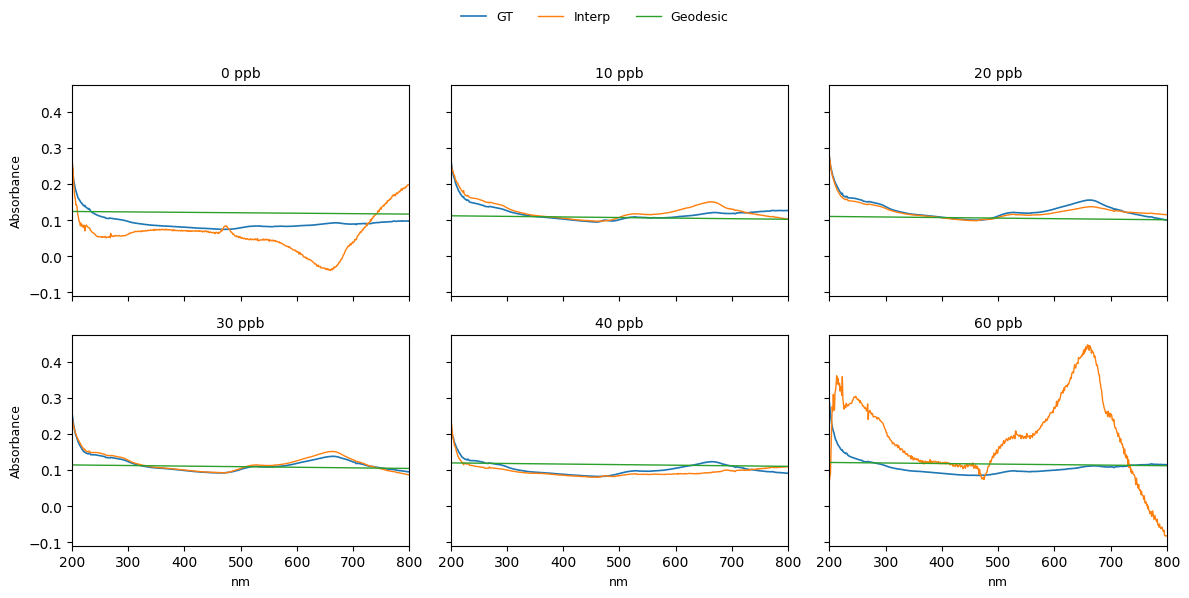

Saved 6-panel: /content/drive/My Drive/RegeneronSTS/visualizations/loo_6panel_comparison.png
Pre-computing Christoffel grid (1000, 301)...
  Computation time: 0.00s
  Grid memory: 0.57 MB
  Grid range: Γ ∈ [-0.0435, -0.0382]
DEBUG: c_sources range: [-0.845, -0.845]
DEBUG: c_targets range: [-1.352, -1.352]
DEBUG: c_final range: [-1.347, -1.347]
DEBUG: errors range: [0.005034, 0.005274]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 100.0%
DEBUG: Final best errors range: [0.000235, 0.000247]
DEBUG: Number converged: 31/31
DEBUG: c_sources range: [-0.845, -0.845]
DEBUG: c_targets range: [-1.225, -1.225]
DEBUG: c_final range: [-1.223, -1.222]
DEBUG: errors range: [0.002914, 0.002990]
DEBUG: tolerance: 0.001
DEBUG: Final convergence rate: 100.0%
DEBUG: Final best errors range: [0.000964, 0.000990]
DEBUG: Number converged: 31/31
DEBUG: c_sources range: [-0.845, -0.845]
DEBUG: c_targets range: [-1.099, -1.099]
DEBUG: c_final range: [-1.097, -1.097]
DEBUG: errors range: [0.001299, 0.00


All visualizations complete
View at: /content/drive/My Drive/RegeneronSTS/visualizations/loo_all_holdouts_comparison.html


In [36]:
## 8. Main Training Execution  — loop over 6 holdouts, save weights, write CSVs, then make visuals

import os, torch, pandas as pd, numpy as np
print("Starting 6-by-LOO training and evaluation")

# Train 6 separate models and save best weights
df_tmp = pd.read_csv(DATA_PATH)
all_concs = [float(c) for c in df_tmp.columns[1:]]
model_paths = {}

for holdout_idx, conc in enumerate(all_concs):
    print("\n" + "="*60)
    print(f" Training with holdout {int(conc)} ppb")
    print("="*60)

    dataset_loo = SpectralDataset(csv_path=DATA_PATH, excluded_concentration_idx=holdout_idx,
                                  normalize=True, device=device)
    model_loo = GeodesicNODE(
        metric_hidden_dims=[128, 256],
        flow_hidden_dims=[64, 128],
        n_trajectory_points=A100_CONFIG['n_trajectory_points'],
        shooting_max_iter=A100_CONFIG['shooting_max_iter'],
        shooting_tolerance=A100_CONFIG['shooting_tolerance'],
        shooting_learning_rate=A100_CONFIG['shooting_learning_rate'],
        christoffel_grid_size=A100_CONFIG['christoffel_grid_size'],
        device=device,
        use_adjoint=True
    )
    best_path = os.path.join(MODEL_DIR, f"best_holdout_{int(conc)}ppb.ckpt")
    ckpt_path = os.path.join(MODEL_DIR, f"ckpt_holdout_{int(conc)}ppb.ckpt")

    _ = train_geodesic_model(
        model=model_loo,
        dataset=dataset_loo,
        config=A100_CONFIG,
        checkpoint_path=ckpt_path,
        best_path=best_path
    )

    # Save a clean weight file per holdout
    wpath = os.path.join(MODEL_DIR, f"model_holdout_{int(conc)}ppb.pth")
    torch.save(model_loo.state_dict(), wpath)
    model_paths[_conc_key(conc)] = wpath

    del model_loo
    torch.cuda.empty_cache()

# Build the two clean CSVs using the saved models
metrics_csv = os.path.join(MODEL_DIR, "loo_metrics_20p.csv")
preds_csv = os.path.join(MODEL_DIR, "loo_predictions.csv")
collect_loo_metrics_and_predictions_csvs(model_paths_by_conc=model_paths,
                                         csv_path=DATA_PATH,
                                         metrics_csv_path=metrics_csv,
                                         preds_csv_path=preds_csv)

# Minimal 2x3 panel from the predictions CSV (clean styling)
import matplotlib.pyplot as plt
viz = pd.read_csv(preds_csv)
order = [0.0, 10.0, 20.0, 30.0, 40.0, 60.0]
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.ravel()
for ax, conc in zip(axes, order):
    sub = viz[viz['Concentration_ppb'] == conc]
    wl = sub['Wavelength_nm'].values
    ax.plot(wl, sub['Actual'].values, linewidth=1.2, label='GT')
    ax.plot(wl, sub['BasicInterp'].values, linewidth=1.0, label='Interp')
    ax.plot(wl, sub['Geodesic'].values, linewidth=1.0, label='Geodesic')
    ax.set_title(f'{int(conc)} ppb', fontsize=10)
    ax.set_xlim(200, 800)
for i, ax in enumerate(axes):
    if i >= 3: ax.set_xlabel('nm', fontsize=9)
    if i % 3 == 0: ax.set_ylabel('Absorbance', fontsize=9)
fig.legend(['GT', 'Interp', 'Geodesic'], loc='upper center', ncol=3, frameon=False, fontsize=9)
plt.tight_layout(rect=[0, 0, 1, 0.92])

sixpanel_path = os.path.join(VIZ_DIR, "loo_6panel_comparison.png")
plt.savefig(sixpanel_path, dpi=150)
plt.show()
print(f"Saved 6-panel: {sixpanel_path}")

# Full 3D visuals across all holdouts using distinct models and full geodesic surfaces
viz_path = os.path.join(VIZ_DIR, "loo_all_holdouts_comparison.html")
fig3d = create_3d_comparison_all_holdouts(model_paths_by_conc=model_paths, csv_path=DATA_PATH, save_path=viz_path)
fig3d.show()
print("\nAll visualizations complete")
print(f"View at: {viz_path}")